# Customer Churn Prediction and Segmentation

### Objective
To predict customer churn and segment customers for targeted retention strategies.

### Dataset
Telco Customer Churn dataset, obtained from Kaggle, containing customer demographic, service usage, and churn information.

### Key Project Steps
1.  **Data Loading**: Initial loading of the dataset.
2.  **Data Cleaning**: Handling missing values, converting data types, and removing duplicates.
3.  **Exploratory Data Analysis (EDA)**: Visualizing distributions of numerical features, examining relationships between features and churn, and correlation analysis.
4.  **Feature Selection**: Identifying relevant numerical and categorical features using correlation and Chi-squared tests.
5.  **Data Preprocessing**: Scaling numerical features with `MinMaxScaler` and encoding categorical features with `OneHotEncoder`.
6.  **Model Training**: Training and hyperparameter tuning (using `GridSearchCV`) for various classification models.
7.  **Model Evaluation**: Assessing model performance using metrics like Accuracy, Recall, Confusion Matrix, and ROC AUC curves.
8.  **Customer Segmentation**: Applying K-Means clustering to segment customers based on their characteristics and predicted churn probability.

### Models Used
*   **For Churn Prediction**: `RandomForestClassifier`, `XGBClassifier`, `LGBMClassifier`.
*   **For Customer Segmentation**: `KMeans`.

### Key Findings
*   **Model Performance**: LightGBM emerged as the best-performing predictive model, demonstrating the highest AUC score of 0.836, coupled with strong recall (0.82) and accuracy (0.728), making it effective for identifying potential churners, especially given the class imbalance.
*   **Clustering Analysis**: The project successfully segmented customers into 4 distinct clusters. Clusters 0 and 3 were identified as high-churn risk groups, characterized by month-to-month contracts, electronic payment methods, and fiber optic internet service, often with lower tenure and total charges. This highlights specific customer behaviors and service types associated with higher churn probability.

### Business Impact
This project provides a dual approach to tackling customer churn. The predictive models enable proactive identification of individual customers at risk of churning, allowing for timely intervention. Simultaneously, the clustering analysis offers a strategic understanding of *why* different customer segments churn, facilitating the development and implementation of highly tailored and cost-effective retention strategies. By understanding both *who* is likely to churn and *which groups* share common churn-driving characteristics, the business can optimize resource allocation and improve customer satisfaction and loyalty, ultimately reducing overall churn.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

import joblib

Import the `warnings` module and sets up a filter to ignore `FutureWarning` messages.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

Define the dataset name as 'blastchar/telco-customer-churn' and uses `kagglehub.load_dataset` to load the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file into a pandas DataFrame named `df`.

In [3]:
df = pd.read_csv("Data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Call the `info()` method on the DataFrame `df` to display a concise summary of the DataFrame. This includes the index dtype and column dtypes, non-null values, and memory usage.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleaning

Convert the 'TotalCharges' column to a numeric data type.

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Remove rows where 'TotalCharges' contains `NaN` values.

In [7]:
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)
df.shape

(7032, 21)

Remove any duplicate rows from the DataFrame.

In [8]:
df = df.drop_duplicates()
df.shape

(7032, 21)

Define a list `num_cols`.

In [9]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

## EDA

Iterate through each numerical column defined in `num_cols`. For each column, it generates a histogram to visualize the distribution of the data

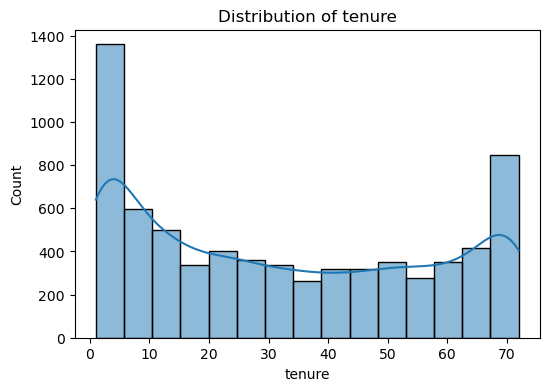

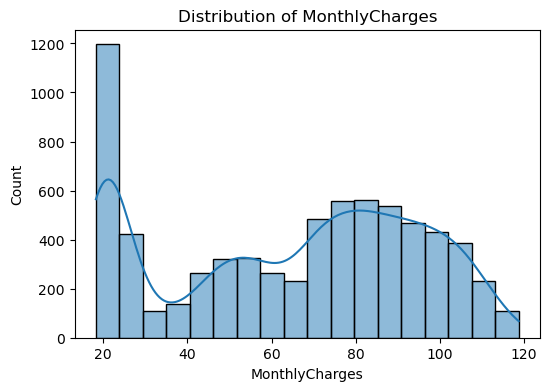

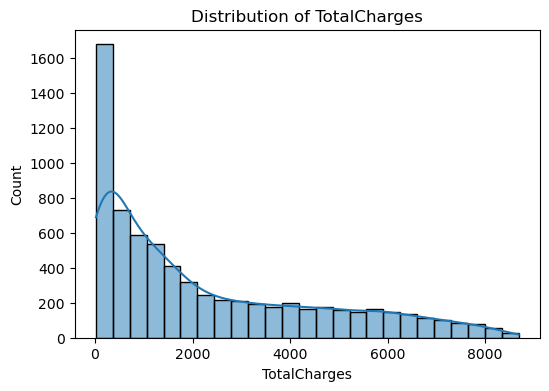

In [10]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

Iterate through each numerical column in `num_cols` and generates a bar plot to visualize the relationship between each numerical feature and the 'Churn' target variable.

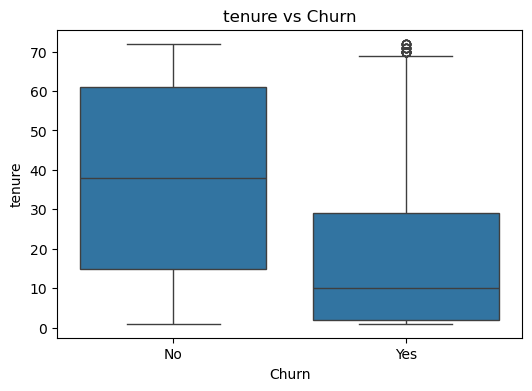

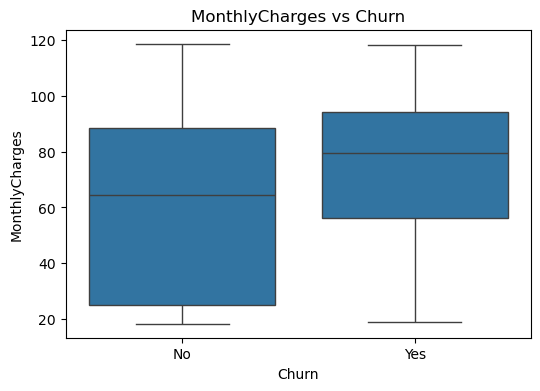

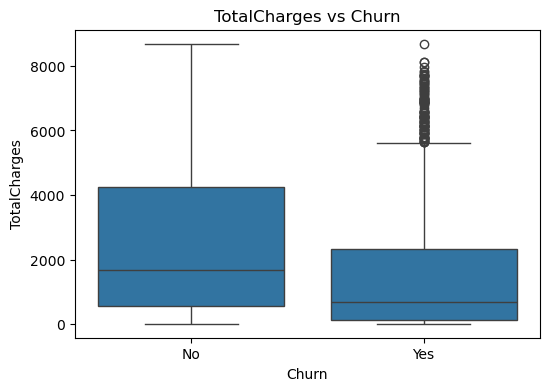

In [11]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Churn", y=col)
    plt.title(f"{col} vs Churn")
    plt.show()

Generate a correlation heatmap for the numerical columns in `num_cols`.

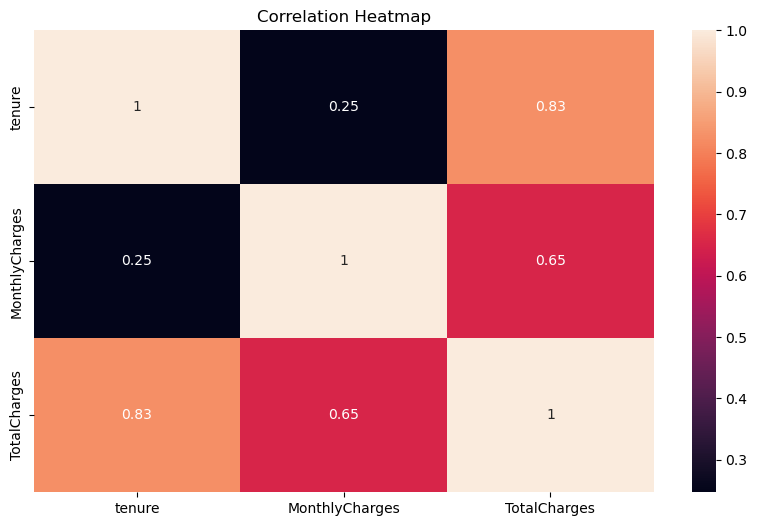

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()

## Feature Selection

Convert the 'gender' column from categorical ('Male', 'Female') to numerical (1, 0).

In [13]:
df['gender'] = df['gender'].map({'Male':1, 'Female':0})

Convert the 'Churn' column from categorical ('Yes', 'No') to numerical (1, 0).

In [14]:
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,1,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,1,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,0,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Numerical Feature Selection

Generate a correlation heatmap specifically for the numerical features and the 'Churn' target variable.

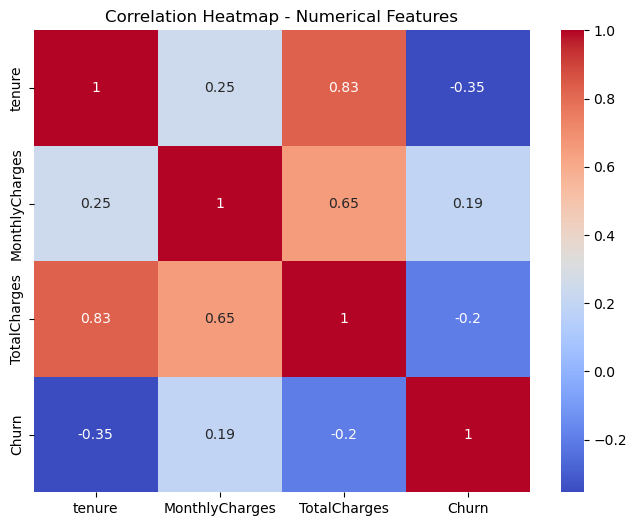

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + ["Churn"]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap - Numerical Features")
plt.show()

Define `num_features` as the list of numerical columns chosen for the model.

In [16]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

### Categorical Feature Selection

Create a list `cat_cols` containing all categorical column names by excluding numerical columns, the 'Churn' target variable, and the 'customerID' identifier from the DataFrame's columns.

In [17]:
cat_cols = [col for col in df.columns
                    if col not in num_cols + ["Churn", "customerID"]]

Create a copy of the DataFrame `df` named `df_encoded`. then iterate through each column in `cat_cols` and apply `LabelEncoder()` to transform the categorical values into numerical labels.

In [18]:
df_encoded = df.copy()
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

Separate the features and target variable for categorical feature selection.

In [19]:
x_cat = df_encoded[cat_cols]
y = df_encoded['Churn']

Calculate the Chi-squared statistics and p-values for the categorical features (`x_cat`) against the target variable (`y`) using `chi2`.

In [20]:
chi_scores, p_values = chi2(x_cat,y)

Organize the Chi-squared test results into a pandas DataFrame `chi2_results`. Include the 'Feature' name, its 'Chi2 Score', and the corresponding 'p-value'.

In [21]:
chi2_results = pd.DataFrame({
    'Feature': cat_cols,
    'Chi2 Score': chi_scores,
    'p-value': p_values
}).sort_values(by="Chi2 Score", ascending=False)

Visualize the Chi-squared scores for categorical features using a bar plot.

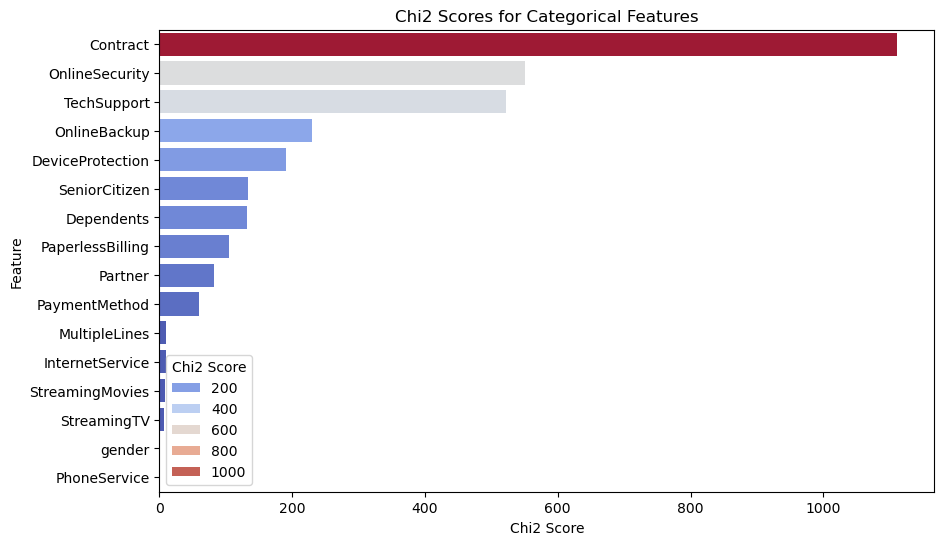

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(y='Feature', x='Chi2 Score', data=chi2_results, palette='coolwarm', hue='Chi2 Score')
plt.xlabel('Chi2 Score')
plt.title('Chi2 Scores for Categorical Features')
plt.show()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   int64  
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


Define a list `cat_features` containing the selected categorical columns that will be used in the model. These features were likely chosen based on their relevance and insights gained from the Chi-squared analysis.

In [24]:
cat_features = ['Contract', 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'DeviceProtection', 'SeniorCitizen', 'Dependents', 'Partner', 'PaymentMethod']

## Preprocessing

Prepare the data for model training by creating `x` (features) and `y` (target).

In [25]:
x = df[num_features + cat_features]
y = df['Churn']

Split the dataset into training and testing sets. Allocate 80% of the data for training and 20% for testing.

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42, stratify=y)

Define a `ColumnTransformer` named `preprocessor`.use it to avoid data leakage.

In [27]:
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])

## Training Model

### Random Forest

Define the hyperparameter grid `param_grid_rf` for `RandomForestClassifier`.

In [28]:
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 3, 4],
    'model__max_features': ['sqrt', 'log2']
}

Set up a `Pipeline` named `rf_pipeline` for the Random Forest model.

In [29]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

Demonstrate how to perform a GridSearchCV for hyperparameter tuning of the Random Forest model. It would fit the `rf_pipeline` using the defined `param_grid_rf`, performing 5-fold cross-validation and optimizing for 'recall'. It also includes code to print test and train accuracy, best parameters, confusion matrix, and classification report.

In [30]:
grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, n_jobs=-1, scoring='recall')
grid_rf.fit(x_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(x_test)

print("Random Forest - Test Accuracy:", accuracy_score(y_test, best_rf.predict(x_test)))
print("Random Forest - Train Accuracy:", accuracy_score(y_train, best_rf.predict(x_train)))
print("Best Params:", grid_rf.best_params_)
print("confusion_matrix\n", confusion_matrix(y_test, y_pred_rf))
print("classification_report\n", classification_report(y_test, y_pred_rf))

Random Forest - Test Accuracy: 0.7270788912579957
Random Forest - Train Accuracy: 0.7500444444444444
Best Params: {'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 200}
confusion_matrix
 [[719 314]
 [ 70 304]]
classification_report
               precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407



Show how to calculate and visualize the ROC curve and AUC score for the Random Forest model.

AUC Score: 0.8303044970518347


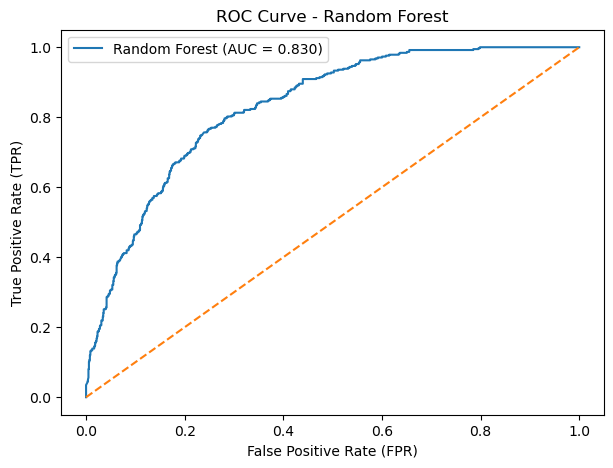

In [31]:
y_proba_rf = best_rf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
auc_score_rf = roc_auc_score(y_test, y_proba_rf)
print("AUC Score:", auc_score_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_score_rf:.3f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

### XGBoost

Define the hyperparameter grid `grid_param_xgb` for the `XGBClassifier`.

In [32]:
grid_param_xgb={
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5]
}

Set up a `Pipeline` named `xgb_pipeline` for the XGBoost model.

In [33]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=2.76))
])

Demonstrate how to perform a GridSearchCV for hyperparameter tuning of the XGBoost model. It would fit the `xgb_pipeline` using the defined `grid_param_xgb`, performing 5-fold cross-validation and optimizing for 'recall'. It also includes code to print test and train accuracy, best parameters, confusion matrix, and classification report.

In [34]:
grid_xgb = GridSearchCV(xgb_pipeline, grid_param_xgb, cv=5, scoring='recall', n_jobs=-1)
grid_xgb.fit(x_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(x_test)

print("XGBoost - Test Accuracy:", accuracy_score(y_test, best_xgb.predict(x_test)))
print("XGBoost - Train Accuracy:", accuracy_score(y_train, best_xgb.predict(x_train)))
print("Best Params:", grid_xgb.best_params_)
print("confusion_matrix\n", confusion_matrix(y_test, y_pred_xgb))
print("classification_report\n", classification_report(y_test, y_pred_xgb))

XGBoost - Test Accuracy: 0.7007818052594172
XGBoost - Train Accuracy: 0.7239111111111111
Best Params: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}
confusion_matrix
 [[675 358]
 [ 63 311]]
classification_report
               precision    recall  f1-score   support

           0       0.91      0.65      0.76      1033
           1       0.46      0.83      0.60       374

    accuracy                           0.70      1407
   macro avg       0.69      0.74      0.68      1407
weighted avg       0.80      0.70      0.72      1407



Show how to calculate and visualize the ROC curve and AUC score for the XGBoost model.

AUC Score: 0.8249439615677301


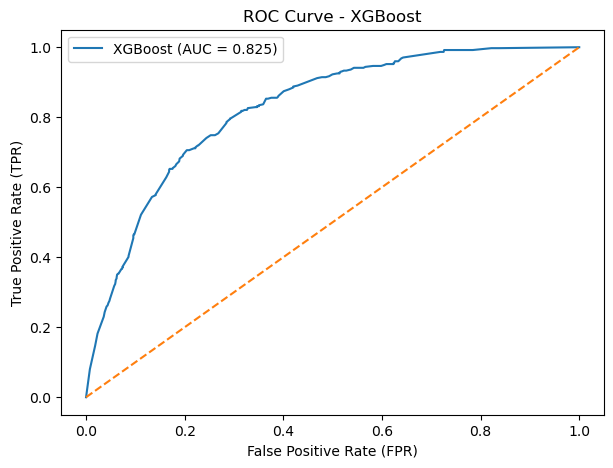

In [35]:
y_proba_xgb = best_xgb.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
auc_score_xgb = roc_auc_score(y_test, y_proba_xgb)
print("AUC Score:", auc_score_xgb)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score_xgb:.3f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

### LightGBM

Set up a `Pipeline` named `lgbm_pipeline` for the LightGBM model

In [36]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, scale_pos_weight=2.76, objective='binary', verbose=-1))
])

Define the hyperparameter grid `grid_param_lgbm` for the `LGBMClassifier`.

In [37]:
grid_param_lgbm={
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
}

Perform a `GridSearchCV` for hyperparameter tuning of the LightGBM model. It fits the `lgbm_pipeline` using the defined `grid_param_lgbm`, performing 5-fold cross-validation and optimizing for 'recall'. After finding the `best_lgbm` estimator, it prints the test and train accuracy, best parameters, confusion matrix, and classification report to evaluate the model's performance.

In [38]:
grid_lgbm = GridSearchCV(lgbm_pipeline, grid_param_lgbm, cv=5, scoring='recall', n_jobs=-1, verbose=0)
grid_lgbm.fit(x_train, y_train)
best_lgbm = grid_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(x_test)

print("LightGBM - Test Accuracy:", accuracy_score(y_test, best_lgbm.predict(x_test)))
print("LightGBM - Train Accuracy:", accuracy_score(y_train, best_lgbm.predict(x_train)))
print("Best Params:", grid_lgbm.best_params_)
print("confusion_matrix\n", confusion_matrix(y_test, y_pred_lgbm))
print("classification_report\n", classification_report(y_test, y_pred_lgbm))

LightGBM - Test Accuracy: 0.7277896233120114
LightGBM - Train Accuracy: 0.7575111111111111
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
confusion_matrix
 [[719 314]
 [ 69 305]]
classification_report
               precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.82      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.80      0.73      0.74      1407



c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Calculate and visualizes the ROC curve and AUC score for the `best_lgbm` (LightGBM) model.

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC Score: 0.8364363698484762


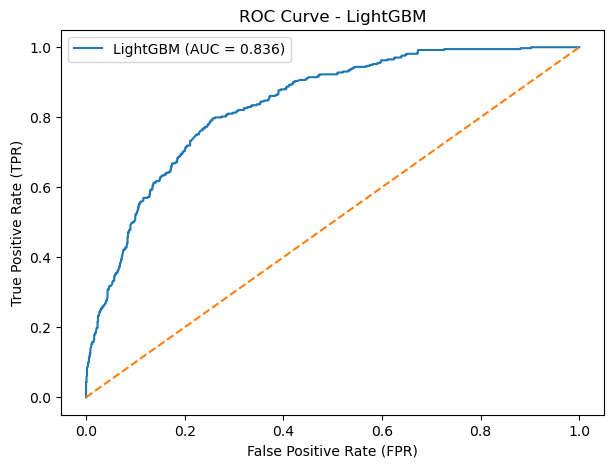

In [39]:
y_proba_lgbm = best_lgbm.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgbm)
auc_score_lgbm = roc_auc_score(y_test, y_proba_lgbm)
print("AUC Score:", auc_score_lgbm)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {auc_score_lgbm:.3f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()

In [40]:
metrics = {
    'RandomForest': {
        'Test Accuracy': 0.7270788912579957,
        'Train Accuracy': 0.7500444444444444,
        'Recall (Churn=1)': 0.81,
        'AUC Score': 0.8303044970518347
    },
    'XGBoost': {
        'Test Accuracy': 0.7007818052594172,
        'Train Accuracy': 0.7239111111111111,
        'Recall (Churn=1)': 0.83,
        'AUC Score': 0.8249439615677301
    },
    'LightGBM': {
        'Test Accuracy': 0.7277896233120114,
        'Train Accuracy': 0.7575111111111111,
        'Recall (Churn=1)': 0.82,
        'AUC Score': 0.8364363698484762
    }
}

metrics_df = pd.DataFrame(metrics).T
print("Model Performance Comparison:")
metrics_df

Model Performance Comparison:


,Test Accuracy,Train Accuracy,Recall (Churn=1),AUC Score
RandomForest,0.727079,0.750044,0.81,0.830304
XGBoost,0.700782,0.723911,0.83,0.824944
LightGBM,0.727790,0.757511,0.82,0.836436


### Model Performance Analysis and Best Model Selection

Based on the performance metrics for Random Forest, XGBoost, and LightGBM, we can conduct a comparative analysis to identify the most suitable model for our customer churn prediction task.


**Detailed Analysis:**

1.  **Recall (Churn=1) Comparison**: Recall for the churn class is a critical metric in customer churn prediction, especially with imbalanced datasets, as it indicates the model's ability to correctly identify actual churners (minimizing false negatives).
    *   **XGBoost** has the highest recall at 0.83.
    *   LightGBM follows closely with a recall of 0.82.
    *   Random Forest has a recall of 0.81.
    This shows that XGBoost is slightly better at capturing positive instances (churners) than the other models.

2.  **AUC Score Comparison**: The Area Under the Receiver Operating Characteristic (ROC) Curve (AUC) provides an aggregate measure of performance across all possible classification thresholds. It indicates how well the model can distinguish between positive and negative classes.
    *   **LightGBM** has the highest AUC score at 0.836.
    *   Random Forest is second with 0.830.
    *   XGBoost has an AUC score of 0.825.
    LightGBM demonstrates the best overall discriminative power.

3.  **Accuracy and Generalization**: While accuracy is a straightforward metric, it can be misleading in imbalanced datasets. However, it's still useful to observe how well the models generalize.
    *   **LightGBM** has the highest Test Accuracy (0.728) and also the highest Train Accuracy (0.758), suggesting good overall performance and minimal overfitting compared to the others.
    *   Random Forest has similar test accuracy (0.727).
    *   XGBoost shows slightly lower test and train accuracies.

**Conclusion and Best Model Selection:**

Considering the importance of identifying actual churners (high recall) while also maintaining strong overall discriminative performance (high AUC) for targeted retention strategies, **LightGBM** stands out as the best-performing model.

While XGBoost achieved the highest recall for the churn class (0.83 vs LightGBM's 0.82), LightGBM demonstrated a superior AUC score (0.836 vs XGBoost's 0.825) and slightly better overall accuracy. The difference in recall is marginal, but LightGBM's higher AUC indicates that it provides a better-calibrated probability output, which is beneficial for setting appropriate thresholds and understanding the confidence of predictions. In a business context where we need to balance identifying as many churners as possible with minimizing false positives (to avoid spending resources on non-churners), LightGBM's strong all-around performance makes it the preferred choice.

Use the `best_lgbm` model to predict churn probabilities for the entire dataset `x`. It then adds these probabilities as a new column named 'Churn_Probability' to the original DataFrame `df`. This allows for a deeper analysis of each customer's likelihood of churning.

In [41]:
churn_probabilities = best_lgbm.predict_proba(x)[:, 1]
df['Churn_Probability'] = churn_probabilities
df.head()

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Probability
0,7590-VHVEG,0,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.812489
1,5575-GNVDE,1,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0.115696
2,3668-QPYBK,1,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0.580911
3,7795-CFOCW,1,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0.116353
4,9237-HQITU,0,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0.821629


## Clustering

Prepare the data for clustering by defining `clustering_features`, which includes all features used for modeling plus the newly calculated 'Churn_Probability'.

In [42]:
clustering_features = x.columns.tolist() + ['Churn_Probability']
x_clust = df[clustering_features]

Define two lists: `numeric_for_clustering` (which includes numerical features and 'Churn_Probability') and `categorical_for_clustering` (which includes the categorical features and 'gender' and 'SeniorCitizen').

In [43]:
numeric_for_clustering = num_features + ['Churn_Probability']
categorical_for_clustering = cat_features + ['gender', 'SeniorCitizen']

Define a `ColumnTransformer` named `kmeans_preprocessor` specifically for K-Means clustering.

In [44]:
kmeans_preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', MinMaxScaler(), numeric_for_clustering),
        ('cat_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ],
    remainder='passthrough'
)

Apply the `kmeans_preprocessor` to the `x_clust` DataFrame.

In [45]:
x_scaled_array = kmeans_preprocessor.fit_transform(x_clust)

Retrieve the names of the transformed features from the `kmeans_preprocessor` and converts them into a list.

In [46]:
feature_names_out = kmeans_preprocessor.get_feature_names_out().tolist()

Convert the `x_scaled_array` into a pandas DataFrame. It then prints the shape of this DataFrame.

In [47]:
x_scaled_df = pd.DataFrame(x_scaled_array, columns=feature_names_out)
print(f"Data Prepared for K-Means. Total features: {x_scaled_df.shape[1]}")

Data Prepared for K-Means. Total features: 29


Implement the Elbow Method to determine the optimal number of clusters (K) for K-Means.

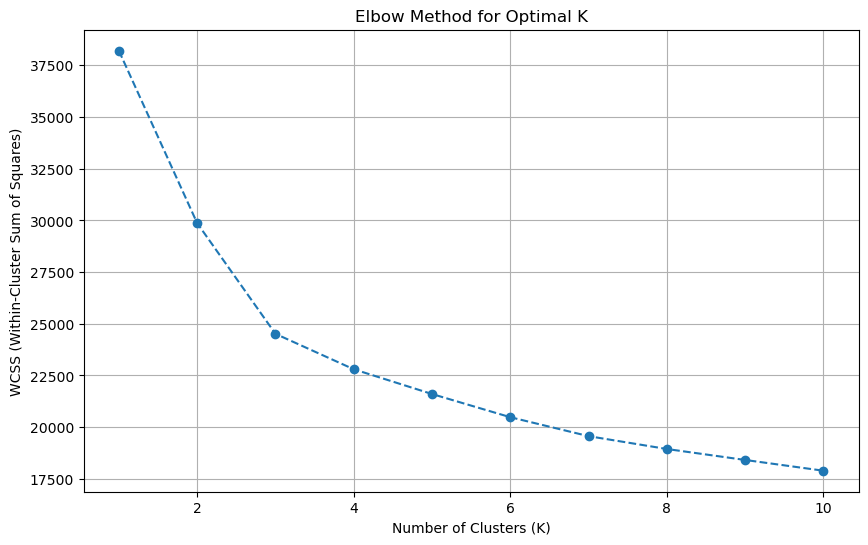

In [ ]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(x_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

Perform K-Means clustering with the optimal number of clusters (`K_OPTIMAL = 4`), determined from the Elbow Method.

In [49]:
K_OPTIMAL = 4

kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(x_scaled_df)

Calculate a summary of each cluster's characteristics.

In [50]:
analysis_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Probability', 'Contract', 'PaymentMethod', 'InternetService']

cluster_summary = df.groupby('Cluster')[analysis_cols].agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'Churn_Probability': 'mean',
    'Contract': lambda x: x.mode()[0],
    'PaymentMethod': lambda x: x.mode()[0],
    'InternetService': lambda x: x.mode()[0]
}).sort_values(by='Churn_Probability', ascending=False)

Calculate and print the distribution of 'Churn' within each cluster, showing the percentage of churned and non-churned customers per cluster.

In [51]:
churn_distribution = df.groupby('Cluster')['Churn'].value_counts(normalize=True).mul(100).unstack().fillna(0).round(2)

print("\n=======================================================")
print("  Analysis of Customer Group Characteristics (K-Means)  ")
print("=======================================================")
print(cluster_summary)

print("\n=======================================================")
print("  Actual distribution of clients in each group (%)  ")
print("=======================================================")
print(churn_distribution)

df.to_csv('Data/customer_data_with_clusters.csv', index=False)


  Analysis of Customer Group Characteristics (K-Means)  
            tenure  MonthlyCharges  TotalCharges  Churn_Probability  \
Cluster                                                               
0        16.488989       71.045483   1258.113236           0.664182   
3        28.943165       77.396187   2383.892086           0.585576   
2        55.063785       83.272615   4708.551318           0.187997   
1        30.667763       21.076283    665.220329           0.167916   

               Contract            PaymentMethod InternetService  
Cluster                                                           
0        Month-to-month         Electronic check     Fiber optic  
3        Month-to-month         Electronic check     Fiber optic  
2              Two year  Credit card (automatic)             DSL  
1              Two year             Mailed check              No  

  Actual distribution of clients in each group (%)  
Churn        0      1
Cluster              
0        52.85 

Visualize the `cluster_summary` DataFrame by plotting the `Churn_Probability`.

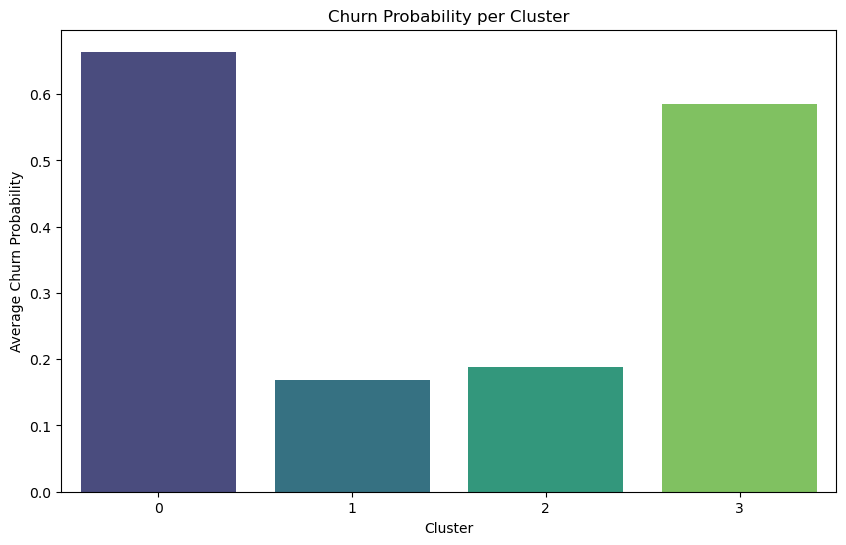

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_summary.index, y='Churn_Probability', data=cluster_summary, palette='viridis')
plt.title('Churn Probability per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Churn Probability')
plt.show()

## Model Saving

In [54]:
lgbm_filename = 'Model_Artifacts/LightGBM_churn_model.pkl'
joblib.dump(best_lgbm, lgbm_filename)

kmeans_filename = 'Model_Artifacts/KMeans_churn_clusters.pkl'
joblib.dump(kmeans, kmeans_filename)

['Model_Artifacts/KMeans_churn_clusters.pkl']

## Summary:

*   **Clustering identified distinct customer segments**: The project successfully segmented customers into 4 clusters. Clusters 0 and 3 were identified as high-churn risk groups, exhibiting average churn probabilities of approximately 0.66 and 0.58, respectively.
*   **High-churn clusters share specific characteristics**: Customers in high-risk Clusters 0 and 3 are predominantly on month-to-month contracts, use electronic check payment methods, and often have fiber optic internet service, coupled with lower average tenure and total charges.
*   **LightGBM is the top-performing churn prediction model**:
    *   **AUC Score**: LightGBM achieved the highest AUC score of 0.836, indicating its superior ability to distinguish between churners and non-churners.
    *   **Recall (Churn=1)**: LightGBM demonstrated a strong Recall of 0.82 for the churn class, closely followed by XGBoost (0.83) and RandomForest (0.81), indicating its effectiveness in identifying actual churners.
    *   **Accuracy**: LightGBM also showed the highest Test Accuracy (0.728) and Train Accuracy (0.758), suggesting good generalization.
*   **Model performance comparison**:
    *   **XGBoost** excelled in identifying actual churners with the highest Recall (0.83).
    *   **RandomForest** showed a balanced performance with a Recall of 0.81 and an AUC of 0.830.